# **Price Prediction Study Notebook**

## Objectives

*   Answer business requirement 1: 
    *  The client is interested to understand the pattern from the data base, so the client can learn the most relevant variables that are correlated to the respective sale price for houses built between 1872 and 2010.


## Inputs
*   outputs/datasets/collection/HousePricePrediction.csv.

## Outputs
* generate code that answers business requirement 1 and can be used to build the Streamlit Apv.




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricePredictionSales.csv")
      .drop(['EnclosedPorch', 'WoodDeckSF'], axis=1))
     
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


# Data Exploration

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Ask mentor for the next step (in thin notebook or the data cleaning)**
Because of the missing data, the information in the graphs does not appear so I decided to do the following: first delete WoodDeckSF as the Missing Data percentage is 89.4%, the rest do not exceed 12% so I decided to fill with the average those data that were numerical but those that were subject to fill it with "missingdata".

# Data Cleaning

## Assessing Missing Data Levels

In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [7]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Dealing with Missing Data

Because of the missing data, the graphs does not appear for the feature_engine.encoding, I decided to do the following steps: 
* first drop EnclosedPorch and WoodDeckSF as the Missing Data percentage is 90.7% and 89.4% respectively.
* The rest, as they not exceed over the 12%: 
    * I decided to fill with the mean those data that were numerical.
    * an in those that were "object", fill it with "missingdata".


## Correlation Study


We use .corr() for spearman and pearson methods, and investigate the top 10 correlations

We know this command returns a pandas series and the first item is the correlation betweSalePriceurn aSalePriceurn, which happens to be 1, so we exclude that with [1:]
We sort values considering the absolute value, by setting key=abs

In [8]:
lst = []
for col in df.columns[df.dtypes!='object'].to_list():
    if col != 'SalePrice':
        df1 = df[df[col]!=0]
        df2 = df1[df1[col].notnull()]
        df3 = df2.filter(['SalePrice', col])
        corr_spearman = df3.corr(method='spearman')['SalePrice'][1:].round(2)
        lst.append(corr_spearman[col])
corr_num = pd.Series(index=df.columns[df.dtypes!='object'].drop(['SalePrice']).to_list(), data=lst).sort_values(key=abs, ascending=False)
print(corr_num)

OverallQual     0.81
GrLivArea       0.73
2ndFlrSF        0.69
YearBuilt       0.65
GarageArea      0.61
GarageYrBlt     0.59
1stFlrSF        0.58
TotalBsmtSF     0.58
YearRemodAdd    0.57
LotArea         0.46
LotFrontage     0.41
BsmtFinSF1      0.40
MasVnrArea      0.33
BedroomAbvGr    0.24
OpenPorchSF     0.16
OverallCond    -0.13
BsmtUnfSF       0.11
dtype: float64


In [9]:
# The dictionary dic maps the ordinal categorical values to integers for the four object variables.
dic = {'BsmtExposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0}, 'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0}, 'GarageFinish': {'Fin': 2, 'RFn': 1, 'Unf': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}
lst = []
# Remove first None and missing values
for col in df.columns[df.dtypes=='object'].to_list():
    df1 = df[df[col]!='None']
    df2 = df1[df1[col].notnull()]
    df3[col] = df2[col].replace(dic[col])
    df4 = df3.filter(['SalePrice', col])
    corr_spearman = df4.corr(method='spearman')['SalePrice'][1:].round(2)
    lst.append(corr_spearman[col])
corr_object = pd.Series(index=df.columns[df.dtypes=='object'].to_list(), data=lst).sort_values(key=abs, ascending=False)
print(corr_object)

KitchenQual     0.67
GarageFinish    0.60
BsmtFinType1    0.33
BsmtExposure    0.30
dtype: float64


In [10]:
corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)
corr_df = pd.DataFrame(index=['SalePrice'], columns=corr.index, data=corr.values.reshape(1,-1).tolist())
corr_df_rev = corr_df[corr_df.columns[::-1]]
corr

/tmp/ipykernel_1861/448136342.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)


OverallQual     0.81
GrLivArea       0.73
2ndFlrSF        0.69
KitchenQual     0.67
YearBuilt       0.65
GarageArea      0.61
GarageFinish    0.60
GarageYrBlt     0.59
1stFlrSF        0.58
TotalBsmtSF     0.58
YearRemodAdd    0.57
LotArea         0.46
LotFrontage     0.41
BsmtFinSF1      0.40
MasVnrArea      0.33
BsmtFinType1    0.33
BsmtExposure    0.30
BedroomAbvGr    0.24
OpenPorchSF     0.16
OverallCond    -0.13
BsmtUnfSF       0.11
dtype: float64

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean   std  min  25%  50%    75%    max
ppscore  462.0  0.065  0.11  0.0  0.0  0.0  0.094  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



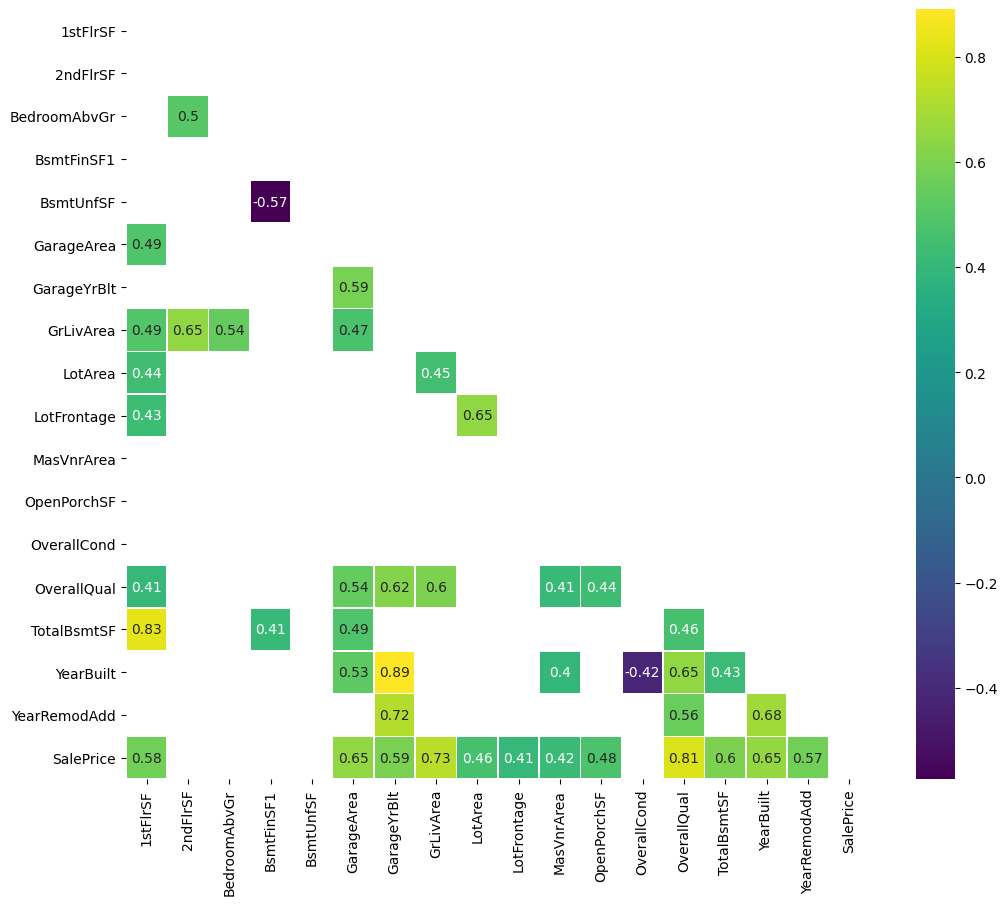



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



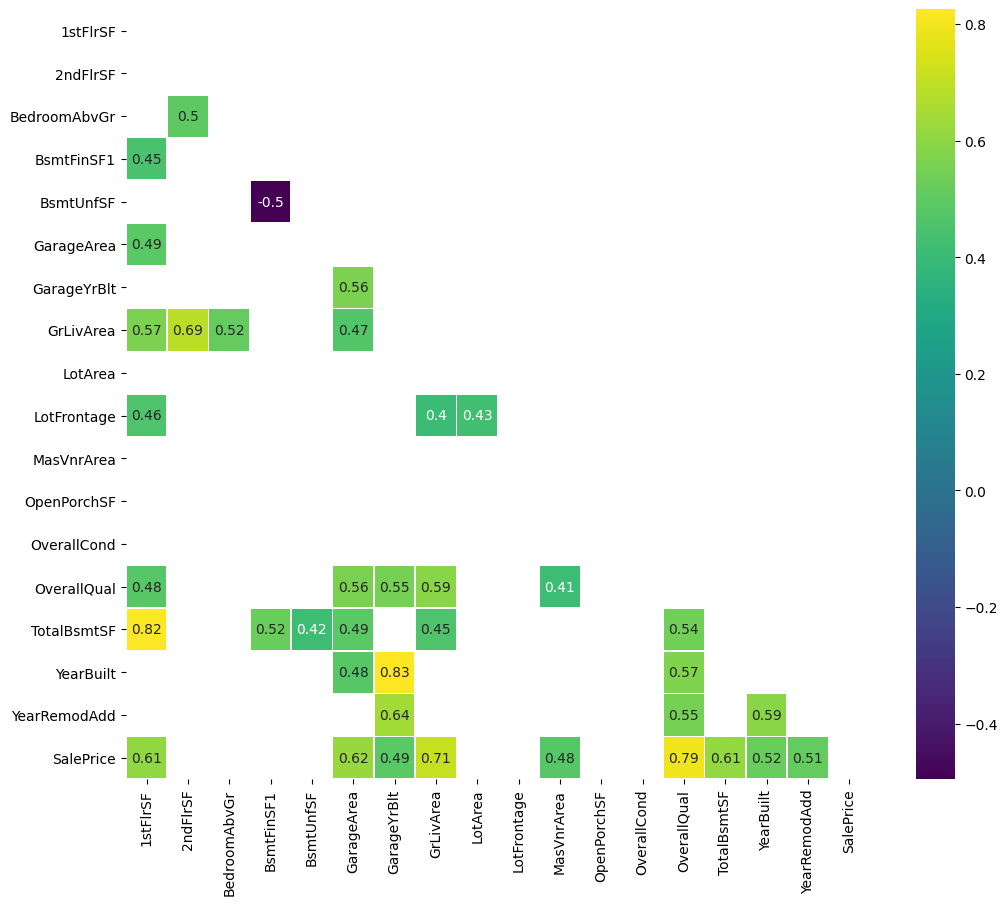



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



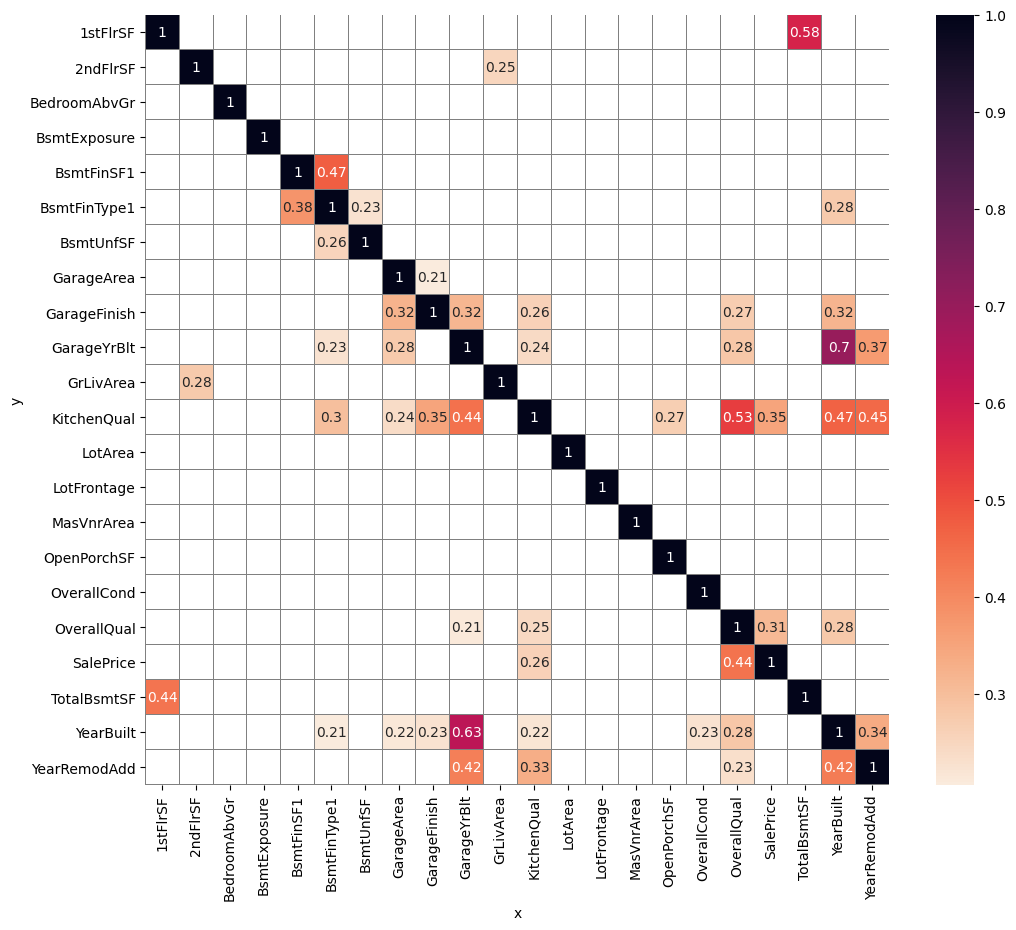

In [12]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

In [14]:
# Calculate the correlation between ‘SalePrice’ and other variables
corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)

# OGet the top 5 values of the ‘corr’ series
top_5 = corr.nlargest(5)

# Display the result
print(top_5)

/tmp/ipykernel_1861/3785417759.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)


OverallQual    0.81
GrLivArea      0.73
2ndFlrSF       0.69
KitchenQual    0.67
YearBuilt      0.65
dtype: float64


Therefore we are studying at df the following variables. We will investigate if:
* The Sales price of the house is correlated to the Rates the overall condition of the house.
* The Sales price of the house is correlated to the Above grade (ground) living area square feet.
* The Sales price of the house is correlated to the Second-floor square feet.
* The Sales price of the house is correlated to the Kitchen quality.
* The Sales price of the house is correlated to the Original construction date.

In [15]:
vars_to_study = ['OverallQual', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'YearBuilt',]
vars_to_study

['OverallQual', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'YearBuilt']

# EDA on selected variables

In [16]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head(5)

,OverallQual,GarageArea,2ndFlrSF,KitchenQual,YearBuilt,SalePrice
0,7,548,854.0,Gd,2003,208500
1,6,460,0.0,TA,1976,181500
2,7,608,866.0,Gd,2001,223500
3,7,642,NaN,Gd,1915,140000
4,8,836,NaN,Gd,2000,250000


## Variable Distribution

In [ ]:
lst = []
for col in df.columns[df.dtypes!='object'].to_list():
    if col != 'SalePrice':
        df1 = df[df[col]!=0]
        df2 = df1[df1[col].notnull()]
        df3 = df2.filter(['SalePrice', col])
        corr_spearman = df3.corr(method='spearman')['SalePrice'][1:].round(2)
        lst.append(corr_spearman[col])
corr_num = pd.Series(index=df.columns[df.dtypes!='object'].drop(['SalePrice']).to_list(), data=lst).sort_values(key=abs, ascending=False)
print(corr_num)

In [ ]:
corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)
corr_df = pd.DataFrame(index=['SalePrice'], columns=corr.index, data=corr.values.reshape(1,-1).tolist())
corr_df_rev = corr_df[corr_df.columns[::-1]]
corr

In [ ]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

In [ ]:
# Calculate the correlation between ‘SalePrice’ and other variables
corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)

# OGet the top 5 values of the ‘corr’ series
top_5 = corr.nlargest(5)

# Display the result
print(top_5)

In [ ]:
vars_to_study = ['OverallQual',
 'GarageArea',
 '2ndFlrSF',
 'KitchenQual',
 'YearBuilt',]
vars_to_study

In [ ]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head(3)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min    25%    50%    75%    max
ppscore   30.0  0.172  0.151  0.0  0.008  0.163  0.258  0.527


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



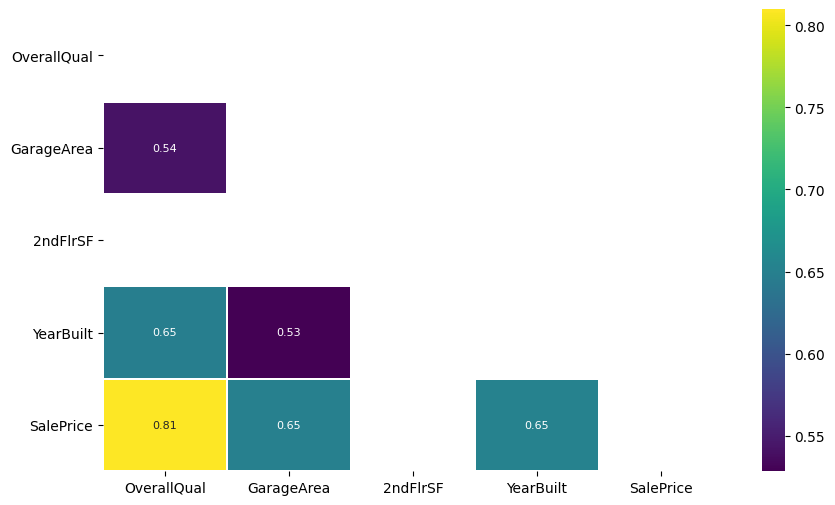



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



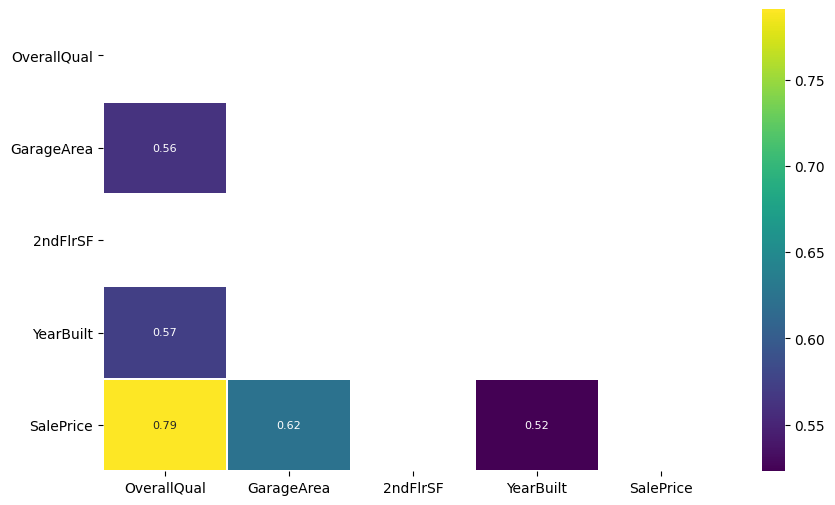



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



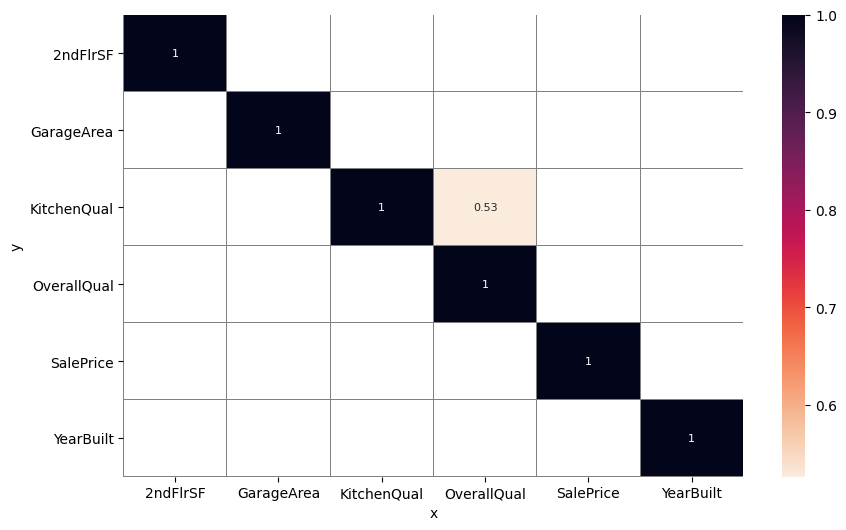

In [17]:
# Definir las funciones que has escrito
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()

def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
   if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

# Seleccionar las variables a estudiar
vars_to_study = ['OverallQual', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'YearBuilt', 'SalePrice']

# Filtrar el DataFrame original por esas columnas
df_filtered = df[vars_to_study]

# Calcular la correlación y el PPS con el DataFrame filtrado
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_filtered)

# Mostrar los resultados con los umbrales y tamaños que quieras
DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold=0.5, PPS_Threshold=0.5,
                      figsize=(10, 6), font_annot=8)

In [18]:
# Code from Code Institute Scikit lesson
sns.set_style("whitegrid")
def plot_histogram_and_boxplot(df):
  for col in df.columns:
    fig, axes = plt.subplots(nrows=2 ,ncols=1 ,figsize=(7,5), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df, x=col, ax=axes[1], whis=3)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0])
    fig.suptitle(f"{col} Distribution - Boxplot and Histogram")
    plt.show()

    # An outlier is defined to be outside the box in the boxplot by three times the
    # interquantile distance
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    print(
        f"This is the range where a datapoint is not an outlier: from "
        f"{(df[col].quantile(q=0.25) - 3*IQR).round(2)} to "
        f"{(df[col].quantile(q=0.75) + 3*IQR).round(2)}")
    print("\n")

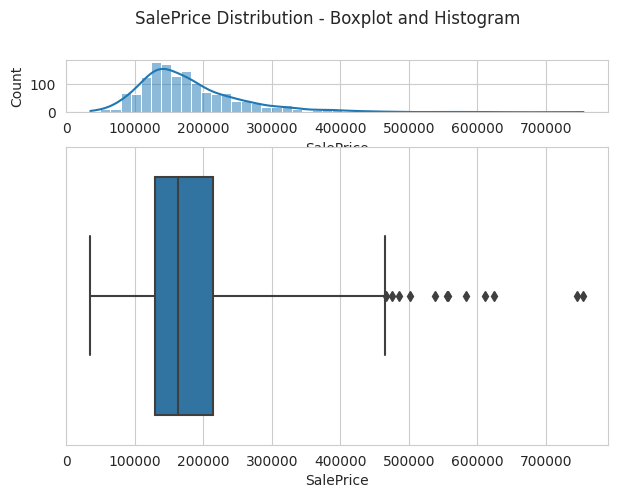

This is the range where a datapoint is not an outlier: from -122100.0 to 466075.0




In [19]:
df2=df.filter(['SalePrice'])
plot_histogram_and_boxplot(df2)

---

# Store correlation coefficients dataframe

In [20]:
import joblib
import os

version = 'v1'
file_path = f'outputs/house_prices_study/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [21]:
corr_df_rev.to_csv(f"{file_path}/corr_df_rev.csv", index=False)

# Store dictionary used for encoding object variables

In [22]:
joblib.dump(value=dic, filename=f"{file_path}/dic.pkl")

['outputs/house_prices_study/v1/dic.pkl']

---

# Conclusions and Next steps

The correlations and plots interpretation converge. 

* The Sales price of the house is strongly correlated to the Rates the overall condition of the house.
* The Sales price of the house is moderately correlated to the Above grade (ground) living area square feet.
* The Sales price of the house is seems thay is not directly correlated to the Second-floor square feet.
* The Sales price of the house is seems thay is not directly correlated to the Kitchen quality.
* The Sales price of the house is a little correlated to the Original construction date.